# Задание по компьютерной лингвистике
### Сопильняк Ольга, группа 495

# Введение

Для создания корпуса текстов используются следующие произведения Фёдора Михайловича Достоевского:
* "Преступление и наказание"
* "Братья Карамазовы"
* "Бедные люди"
* "Бесы"
* "Подросток"

В рамках работы с помощью библиотек NLTK и pymorphy2 был проведен частотный анализ лемм, словоформ, n-грамм словосочетаний и частей речи, а также грамматических категорий, встречающихся в текстах Достоевского. Описан алгоритм, который использует библиотека pymorphy2. Приведены некоторые выводы о возможных способах идентификации авторства на основе полученных данных. В конце задания сформулирован алгоритм формирования относительных придаточных предложений.

# Часть 1. Частотный словарь и закон Ципфа

In [256]:
import numpy as np
import string
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist

%matplotlib inline

Прочитаем все файлы и запишем в одну строку, чтобы в дальнейшем было удобнее работать.

In [145]:
def cat(filename):
    with open(filename, 'r') as f:
        return f.read().replace('\n', '')

In [146]:
data = cat('dost1.txt')
data += cat('dost2.txt')
data += cat('dost3.txt')
data += cat('dost4.txt')
data += cat('dost5.txt')

Разобъем текст на токены и уберем пунктуацию и прочие посторонние символы.

In [147]:
words = nltk.word_tokenize(data)
words = [word.lower() for word in words if word.isalpha()]  # remove punctuation

In [223]:
len(words)

933294

Достаточно много слов, корпус должен получиться неплохой.

In [148]:
print(words[:100])

['достоевский', 'преступление', 'и', 'наказание', 'часть', 'в', 'начале', 'июля', 'в', 'чрезвычайно', 'жаркое', 'время', 'под', 'вечер', 'один', 'молодой', 'человек', 'вышел', 'из', 'своей', 'каморки', 'которую', 'нанимал', 'от', 'жильцов', 'в', 'переулке', 'на', 'улицу', 'и', 'медленно', 'как', 'бы', 'в', 'нерешимости', 'отправился', 'к', 'мосту', 'он', 'благополучно', 'избегнул', 'встречи', 'с', 'своею', 'хозяйкой', 'на', 'лестнице', 'каморка', 'его', 'приходилась', 'под', 'самою', 'кровлей', 'высокого', 'пятиэтажного', 'дома', 'и', 'походила', 'более', 'на', 'шкаф', 'чем', 'на', 'квартиру', 'квартирная', 'же', 'хозяйка', 'его', 'у', 'которой', 'он', 'нанимал', 'эту', 'каморку', 'с', 'обедом', 'и', 'прислугой', 'помещалась', 'одною', 'лестницей', 'ниже', 'в', 'отдельной', 'квартире', 'и', 'каждый', 'раз', 'при', 'выходе', 'на', 'улицу', 'ему', 'непременно', 'надо', 'было', 'проходить', 'мимо', 'хозяйкиной', 'кухни']


### Библиотека pymorphy2

В NLTK лемматизатора для русского языка нет, поэтому будем использовать библиотеку pymorphy2. Она использует словари OpenCorpora, в которой для каждого слова имеются его лексемы.

В общих чертах лемматизатор pymorphy2 работает так: 

* каждое слово можно разбить на префикс + стем + окончание
* если откинуть стем, можно получить набор правил
* для каждой лексемы определяется ее парадигма и удаляются дубликаты
* хранятся только парадигмы и информация о том, по какой парадигме слово изменяется
* для парадигм используется числовое представление для компактности

Если по словарю слово найти нельзя, то в дело идут правила разбора несловарных слов: 
* отсечение неизвестных префиксов
* предсказание по концу слова (когда отсечение префиксов использовать нельзя: правая часть неизвестна либо приставка влияет на разбор)

In [ ]:
!pip3 install pymorphy2
!pip install -U pymorphy2-dicts-ru

In [149]:
import pymorphy2

Применим лемматизатор pymorphy2 и посмотрим, что получается. Однако, недостаток такого разбора -- отсутствие снятия омонимии. Библиотека pymorphy2 выдает все возможные разборы слова и, согласно документации pymorphy2, наиболее вероятный разбор (первый в списке) верен примерно в 79% случаев.

Вероятность правильности разбора определяется как условная вероятность P(tag|word). Она оценивается на основе корпуса OpenCorpora: ищутся все неоднозначные слова со снятой неоднозначностью, для каждого слова считается, сколько раз ему был сопоставлен данный тег, и на основе этих частот вычисляется условная вероятность тега.

In [150]:
morph = pymorphy2.MorphAnalyzer()
for word in words[:50]:
    print(word + " -> " + morph.parse(word)[0].normal_form)

достоевский -> достоевский
преступление -> преступление
и -> и
наказание -> наказание
часть -> часть
в -> в
начале -> начало
июля -> июль
в -> в
чрезвычайно -> чрезвычайно
жаркое -> жаркое
время -> время
под -> под
вечер -> вечер
один -> один
молодой -> молодая
человек -> человек
вышел -> выйти
из -> из
своей -> свой
каморки -> каморка
которую -> который
нанимал -> нанимать
от -> от
жильцов -> жильцов
в -> в
переулке -> переулок
на -> на
улицу -> улица
и -> и
медленно -> медленно
как -> как
бы -> бы
в -> в
нерешимости -> нерешимость
отправился -> отправиться
к -> к
мосту -> мост
он -> он
благополучно -> благополучно
избегнул -> избегнуть
встречи -> встреча
с -> с
своею -> свой
хозяйкой -> хозяйка
на -> на
лестнице -> лестница
каморка -> каморка
его -> он
приходилась -> приходиться


Получается вполне хорошо, поэтому применим алгоритм ко всем словам в списке слов.

In [151]:
words_lemmatized = [morph.parse(word)[0].normal_form for word in words]

Теперь построим по этим данным частотный словарь и запишем его в файл.

In [290]:
def find_freq_dict(wordlist):
    
    dictionary = FreqDist(wordlist)
    
    import operator
    dictionary = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)

    for i in range(len(dictionary)):
        dictionary[i] = (dictionary[i][0], dictionary[i][1] / len(wordlist))
        
    return dictionary

In [291]:
dictionary = find_freq_dict(words_lemmatized)

In [293]:
print(dictionary[:20])

[('и', 0.047514502396886725), ('я', 0.02795046362668141), ('в', 0.02616110250360551), ('он', 0.026023953866627238), ('не', 0.023119188594376477), ('что', 0.020050487841987628), ('быть', 0.014209884559420719), ('с', 0.013773794752778868), ('на', 0.012389450698279427), ('весь', 0.011901930152770725), ('вы', 0.010602232522656312), ('это', 0.010396509567188903), ('а', 0.009728981435646216), ('она', 0.009473970688764741), ('как', 0.009110741095517598), ('но', 0.00806926863346384), ('к', 0.00654134709962777), ('же', 0.0064481288854316005), ('так', 0.00614490182086245), ('тот', 0.005446300951254374)]


In [294]:
output = open('out_freq.txt', 'w', encoding="utf-8")
output.write('%s' % dictionary[:1000])
output.close()

Проверим, выполняется ли закон Ципфа: частота слов обратно пропорциональна их индексам в отсортированном частотном словаре.

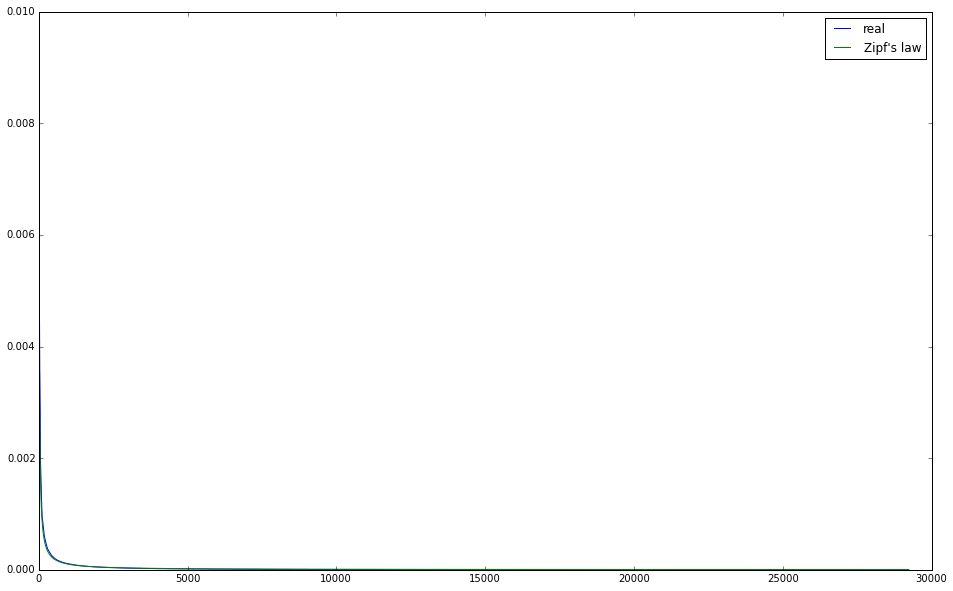

In [295]:
plt.figure(figsize=(16, 10))
plt.plot([dictionary[i][1] for i in range(len(dictionary))], label='real')
plt.plot([0.1 / i for i in range(1, len(dictionary))], label='Zipf\'s law')
plt.ylim(ymax=0.01)
plt.legend()
plt.show()

Из графика видно, что примерное совпадение наблюдается.

# Часть 2. N-граммы на уровне словосочетаний

Теперь построим n-граммы (для n = 3, n = 4) словосочетаний, встречающихся в тексте.

In [296]:
def find_ngrams_statistics(words_array, n, is_freq=True):
    
    from nltk import ngrams
    
    sentence_pos = ' '.join(str(word) for word in words_array)
    
    sixgrams = ngrams(sentence_pos.split(), n)
    ngrams = []
    for grams in sixgrams:
        ngrams.append(' '.join(grams))
    
    ngrams_statistics = {}

    for ngram in ngrams:
        if not ngram in ngrams_statistics:
            ngrams_statistics.update({ngram : 1})
        else:
            ngram_occurrences = ngrams_statistics[ngram]
            ngrams_statistics.update({ngram : ngram_occurrences + 1})
            
    import operator
    ngrams_statistics_sorted = sorted(ngrams_statistics.items(), \
                               key=operator.itemgetter(1), \
                               reverse=True)
    
    if is_freq:
        ngrams_statistics_sorted = [(number[0], number[1] / len(ngrams)) 
                                for number in ngrams_statistics_sorted]

    return ngrams_statistics_sorted

n = 3

In [322]:
ngrams = find_ngrams_statistics(words, n=3)

In [323]:
ngrams[:10]

[('по крайней мере', 0.00032358575879788963),
 ('в самом деле', 0.00026465457755986334),
 ('до сих пор', 0.00024858243722221987),
 ('в том что', 0.0002057233963218371),
 ('а между тем', 0.0001917942080292127),
 ('в то же', 0.00017465059166905963),
 ('может быть и', 0.00017465059166905963),
 ('о том что', 0.00017357911564655007),
 ('к тому же', 0.00017036468757902136),
 ('и как бы', 0.00016179287939894482)]

In [324]:
output = open('out_3grams.txt', 'w', encoding="utf-8")
output.write('%s' % ngrams[:1000])
output.close()

n = 4

In [161]:
ngrams = find_ngrams_statistics(words, n=4)

In [162]:
ngrams[:10]

[('в то же время', 0.0001542927125623198),
 ('несмотря на то что', 8.464669647516155e-05),
 ('ни за что не', 7.39319247694449e-05),
 ('и в то же', 6.964601608715823e-05),
 ('и в самом деле', 6.536010740487157e-05),
 ('до сих пор не', 4.92879498462966e-05),
 ('соч в т с', 4.714499550515327e-05),
 ('собр соч в т', 4.393056399343828e-05),
 ('дело в том что', 4.285908682286661e-05),
 ('с там же с', 3.964465531115161e-05)]

In [222]:
output = open('out_4grams.txt', 'w', encoding="utf-8")
output.write('%s' % ngrams[:1000])
output.close()

# Часть 3. N-граммы на уровне частей речи

Библиотека pymorphy2, основываясь на данных OpenCorpora, позволяет определить часть речи слова. Построим n-граммы по этим данным.

In [ ]:
tags = [morph.parse(word)[0].tag for word in words]

In [164]:
for word in words[:20]:
    print(word + " -> " + morph.parse(word)[0].tag.POS)

достоевский -> NOUN
преступление -> NOUN
и -> CONJ
наказание -> NOUN
часть -> NOUN
в -> PREP
начале -> NOUN
июля -> NOUN
в -> PREP
чрезвычайно -> ADVB
жаркое -> NOUN
время -> NOUN
под -> PREP
вечер -> NOUN
один -> ADJF
молодой -> NOUN
человек -> NOUN
вышел -> VERB
из -> PREP
своей -> ADJF


In [178]:
pos = [tag.POS for tag in tags]

In [179]:
def find_ngrams_statistics(words_array, n, is_freq=True):
    
    from nltk import ngrams
    
    sentence_pos = ' '.join(str(word) for word in words_array)
    
    sixgrams = ngrams(sentence_pos.split(), n)
    ngrams = []
    for grams in sixgrams:
        ngrams.append(' '.join(grams))
    
    ngrams_statistics = {}

    for ngram in ngrams:
        if not ngram in ngrams_statistics:
            ngrams_statistics.update({ngram : 1})
        else:
            ngram_occurrences = ngrams_statistics[ngram]
            ngrams_statistics.update({ngram : ngram_occurrences + 1})
            
    import operator
    ngrams_statistics_sorted = sorted(ngrams_statistics.items(), \
                               key=operator.itemgetter(1), \
                               reverse=True)
    
    if is_freq:
        ngrams_statistics_sorted = [(number[0], number[1] / len(ngrams)) 
                                for number in ngrams_statistics_sorted]

    return ngrams_statistics_sorted

In [180]:
ngrams_statistics = find_ngrams_statistics(pos, 3)

In [181]:
ngrams_statistics[:20]

[('PREP ADJF NOUN', 0.015923205170514695),
 ('NOUN PREP NOUN', 0.012606986880847581),
 ('ADJF NOUN CONJ', 0.010029015570689559),
 ('PREP NOUN NOUN', 0.009711858668026726),
 ('VERB PREP NOUN', 0.009374343720936212),
 ('NOUN NOUN NOUN', 0.00921040788949225),
 ('PREP NOUN CONJ', 0.00848716157429829),
 ('ADJF NOUN NOUN', 0.00799213965189887),
 ('NOUN ADJF NOUN', 0.007909635998165633),
 ('NOUN PREP ADJF', 0.007500332157566978),
 ('ADJF ADJF NOUN', 0.007443543928373971),
 ('ADJF NOUN PREP', 0.00702352532755022),
 ('ADJF NOUN VERB', 0.006806015694980778),
 ('NOUN NOUN CONJ', 0.006531717833218328),
 ('NOUN NOUN VERB', 0.006466357795845245),
 ('NOUN CONJ NOUN', 0.006275635063838541),
 ('PREP NOUN VERB', 0.005795613805754255),
 ('CONJ NPRO VERB', 0.005537388084329449),
 ('PREP NOUN PREP', 0.005384167013110581),
 ('ADJF NOUN ADJF', 0.005326307307895064)]

In [182]:
output = open('out_ngrams_pos.txt', 'w', encoding="utf-8")
output.write('%s' % ngrams_statistics[:1000])
output.close()

# Часть 4. Статистика по различным грамматическим значениям

### Падеж

In [297]:
case = [tag.case for tag in tags]
case = list(filter(lambda a: a != None, case))
dict_case = find_freq_dict(case)

In [298]:
dict_case[:20]

[('nomn', 0.39883146203005815),
 ('gent', 0.2428336542957849),
 ('accs', 0.1357822014169277),
 ('datv', 0.08235075246001378),
 ('ablt', 0.07285763848733665),
 ('loct', 0.06296730205499772),
 ('loc2', 0.002026337357515298),
 ('gen2', 0.0013173706890049828),
 ('voct', 0.0010332812083607785)]

In [299]:
output = open('out_case.txt', 'w', encoding="utf-8")
output.write('%s' % dict_case[:1000])
output.close()

Преобладает именительный падеж. Как покажет позже сравнение с другими авторами, это скорее особенность языка, а не автора.

### Время

In [300]:
tense = [tag.tense for tag in tags]
tense = list(filter(lambda a: a != None, tense))
dict_tense = find_freq_dict(tense)

In [301]:
dict_tense[:20]

[('past', 0.6401405628238528),
 ('pres', 0.2675918238813661),
 ('futr', 0.09226761329478114)]

In [302]:
output = open('out_tense.txt', 'w', encoding="utf-8")
output.write('%s' % dict_tense[:1000])
output.close()

Тут преобладает прошедшее время. Это, во-первых, можно объяснить жанром (все выбранные произведения Достоевского -- романы), а во-вторых, можно списать на авторскую специфику.

### Род

In [306]:
gender = [tag.gender for tag in tags]
gender = list(filter(lambda a: a != None, gender))
dict_gender = find_freq_dict(gender)

In [307]:
dict_gender[:20]

[('masc', 0.513381864623244),
 ('femn', 0.3059693486590038),
 ('neut', 0.18064878671775222)]

In [308]:
output = open('out_gender.txt', 'w', encoding="utf-8")
output.write('%s' % dict_gender[:1000])
output.close()

51% -- мужской род, 31% -- женский, 18% -- средний.

### Залог

In [310]:
voice = [tag.voice for tag in tags]
voice = list(filter(lambda a: a != None, voice))
dict_voice = find_freq_dict(voice)

In [311]:
dict_voice[:20]

[('pssv', 0.5812000819168543), ('actv', 0.4187999180831456)]

In [312]:
output = open('out_voice.txt', 'w', encoding="utf-8")
output.write('%s' % dict_voice[:1000])
output.close()

На основе этой характеристики также можно анализировать специфику автора: 58% пассивного залога, 42% -- активного.

### Включенность говорящего в действие

In [313]:
involvement = [tag.involvement for tag in tags]
involvement = list(filter(lambda a: a != None, involvement))
dict_involvement = find_freq_dict(involvement)

In [314]:
dict_involvement[:20]

[('excl', 0.9885553159727981), ('incl', 0.011444684027201857)]

In [315]:
output = open('out_involvement.txt', 'w', encoding="utf-8")
output.write('%s' % dict_involvement[:1000])
output.close()

### Лицо

In [316]:
person = [tag.person for tag in tags]
person = list(filter(lambda a: a != None, person))
dict_person = find_freq_dict(person)

In [317]:
dict_person[:20]

[('3per', 0.4696981059753852),
 ('1per', 0.35294852886033545),
 ('2per', 0.17735336516427935)]

In [318]:
output = open('out_person.txt', 'w', encoding="utf-8")
output.write('%s' % dict_person[:1000])
output.close()

Здесь опять же скорее специфика жанра: мало диалогов и много описаний, поэтому преобладает третье лицо.

### Одушевленность

In [319]:
animacy = [tag.animacy for tag in tags]
animacy = list(filter(lambda a: a != None, animacy))
dict_animacy = find_freq_dict(animacy)

In [320]:
dict_animacy[:20]

[('inan', 0.6859975303232488), ('anim', 0.31400246967675116)]

In [321]:
output = open('out_animacy.txt', 'w', encoding="utf-8")
output.write('%s' % dict_animacy[:1000])
output.close()

Вполне вероятно, что эта грамматическая категория не несет много информации.

# Часть 5. Сравнение с другими авторами и выводы о возможных способах идентификации авторства

Было проведено сравнение с корпусами текстов А.С. Грибоедова (Ирина Гавенко) и М.Е. Салтыкова-Щедрина (Павел Воропаев).

### Частота лексем

Список наиболее часто встречающихся лексем у всех авторов практически совпадает со аналогичным общим списком для русского языка, поэтому такой признак вряд ли можно использовать для идентификации авторства. Однако, интерес могут представлять частотные словари с отсечением наиболее часто встречающихся слов (предлогов, личных местоимений и пр.)

### N-граммы на уровне словосочетаний

Хорошо заметна авторская специфика: уникальные наиболее часто встречающиеся словосочетания. Для Достоевского это "может быть и", "в самом деле", "несмотря на то что". Для Салтыкова-Щедрина -- "с одной стороны", "с другой стороны", "тем не менее", "не только не", "до такой степени". Также встречаются и общие, часто встречающиеся в русском языке как таковом: "по крайней мере", "в то же время". Для Грибоедова данные могут быть испорчены небольшим объемом корпуса, но прослеживаются часто встречающиеся разговорные выражения: "ах боже мой", "ха ха ха", "с ума сошел", а также характерное для пьесы "в сторону".

Однако, для идентификации авторства одного (возможно, небольшого) произведения такой способ может не подойти, потому что часто употребляемые автором выражения заметны только на достаточно больших данных.


### N-граммы на уровне частей речи

Здесь встречаемость у Достоевского и Салтыкова-Щедрина почти совпадает, а у Грибоедова отличается: он гораздо реже использует такую, казалось бы, часто встречающуюся конструкцию, как "прилагательное - существительное" или "предлог - прилагательное - сущестительное", заменяя его "существительное - предлог - существительное" и 3 существительных подряд.

### Статистика по различным грамматическим значениям

Встречаемость **падежей** практически совпадает, поэтому скорее всего этот параметр нельзя использовать для идентификации авторства.

У Достоевского преобладает прошедшее **время**, у Грибоедова -- настоящее. Так как Достоевский писал романы, а Грибоедов -- пьесы, это легко объясняется. А вот у Салтыкова-Щедрина, хотя тоже преобладает прошедшее время, его меньше, чем у Достоевского, это можно объяснить авторством.

**Род** тоже практически совпадает: это тоже можно объяснить особенностями языка.

Соотношение пассивного и активного **залогов** у Достоевского и Грибоедова сильно различаются, причем, как ни странно, у Достоевского они встречаются почти в равной степени, а у Грибоедова сильно преобладает пассивный.

**Лицо** -- скорее всего особенность жанра: в пьесе из-за большого количества диалогов первое лицо встречается чаще. У Салтыкова больше третьего лица, чем у Достоевского, хотя у обоих третье лицо преобладает.

### Выводы

К признакам, позволяющим идентифицировать авторство, можно отнести время и залог, а также наиболее часто встречающиеся n-граммы по леммам, словоформам и частям речи.

# Часть 6. Алгоритм формирования относительных придаточных предложений

* Сделать главным слово, относительно которого происходит формирование относительного придаточного;
* добавить относительное местоимение после главного и построить зависимость от главного слова к нему;
* слово, которое было главным до применения алгоритма, поставить после относительного местоимения и построить зависимость от относительного местоимения к нему;
* непосредственно зависимое от него поставить следующим.

"Джек построил дом" -> "Дом, который построил Джек"